In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 # Install and Import Required Libraries

In [2]:
!pip install rasterio
!pip install tensorflow

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import rasterio
from PIL import Image
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 48.0 MB/s eta 0:00:00


# Load and Explore the Dataset

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


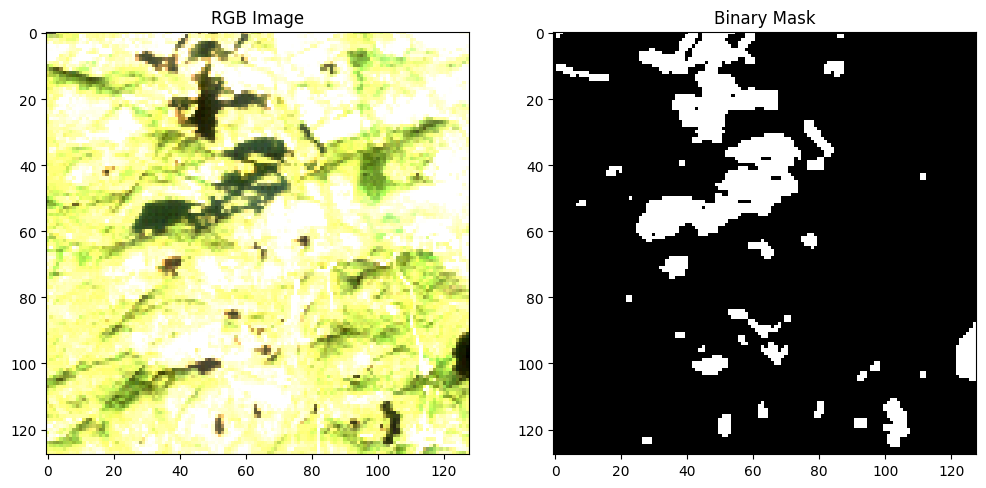

In [3]:

data_dir = "/content/drive/My Drive/Computer_Vision_intern/week_3/data"
image_paths = [os.path.join(data_dir, "images", f"{i}.tif") for i in range(306)]
mask_paths = [os.path.join(data_dir, "labels", f"{i}.png") for i in range(456)]

def visualize_sample(image_path, mask_path):
    with rasterio.open(image_path) as img:
        image = img.read()
        image = np.transpose(image, (1, 2, 0))

    mask = np.array(Image.open(mask_path))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image[:, :, [3, 2, 1]])
    plt.title("RGB Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Binary Mask")
    plt.show()

# Visualize a sample
visualize_sample(image_paths[0], mask_paths[0])

# Preprocessing

In [4]:
def normalize(image):
    return image / 10000.0

class WaterDataset:
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths = mask_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        with rasterio.open(self.image_paths[idx]) as img:
            image = img.read()
            image = np.transpose(image, (1, 2, 0))
            image = normalize(image)
        mask = np.array(Image.open(self.mask_paths[idx]))
        mask = np.expand_dims(mask, axis=-1)
        return image, mask

min_length = min(len(image_paths), len(mask_paths))
image_paths = image_paths[:min_length]
mask_paths = mask_paths[:min_length]

# Split dataset into train, validation, and test
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(image_paths,
                                                                                          mask_paths,
                                                                                          test_size=0.2,
                                                                                          random_state=42)

train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(train_image_paths,
                                                                                        train_mask_paths,
                                                                                        test_size=0.2,
                                                                                        random_state=42)

# Create data set
train_dataset = WaterDataset(train_image_paths, train_mask_paths)
val_dataset = WaterDataset(val_image_paths, val_mask_paths)
test_dataset = WaterDataset(test_image_paths, test_mask_paths)

# Convert data set to tensorflow data set
def tf_dataset(dataset):
    images = np.array([dataset[i][0] for i in range(len(dataset))])
    masks = np.array([dataset[i][1] for i in range(len(dataset))])
    return tf.data.Dataset.from_tensor_slices((images, masks))

train_tf_dataset = tf_dataset(train_dataset).batch(8).prefetch(tf.data.AUTOTUNE)
val_tf_dataset = tf_dataset(val_dataset).batch(8).prefetch(tf.data.AUTOTUNE)
test_tf_dataset = tf_dataset(test_dataset).batch(8).prefetch(tf.data.AUTOTUNE)

# Define the U-Net Model

In [5]:
def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(conv3)

    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    concat1 = layers.concatenate([up1, conv2], axis=-1)
    conv4 = layers.Conv2D(128, 3, activation="relu", padding="same")(concat1)
    conv4 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv4)

    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat2 = layers.concatenate([up2, conv1], axis=-1)
    conv5 = layers.Conv2D(64, 3, activation="relu", padding="same")(concat2)
    conv5 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv5)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(conv5)

    model = tf.keras.Model(inputs, outputs)
    return model

model = unet_model(input_shape=(128, 128, 12))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 12)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          6,976 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 64, 64, 256)    │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 384)    │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 128)    │        442,496 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 128, 128, 128)  │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128, 128, 192)  │              0 │ up_sampling2d_1[0][0], │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 64)   │        110,656 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 1,888,321 (7.20 MB)

 Trainable params: 1,888,321 (7.20 MB)

 Non-trainable params: 0 (0.00 B)

# Check the shape of a sample

In [6]:
sample_image, sample_mask = next(iter(train_tf_dataset))
print("Image shape:", sample_image.shape)
print("Mask shape:", sample_mask.shape)

Image shape: (8, 128, 128, 12)
Mask shape: (8, 128, 128, 1)


# **Train the Model**

In [7]:
# Train the model
history = model.fit(
    train_tf_dataset,
    validation_data=val_tf_dataset,
    epochs=10,
    verbose=1
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 266s 10s/step - accuracy: 0.6941 - loss: 0.5408 - val_accuracy: 0.8332 - val_loss: 1.2556
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 313s 10s/step - accuracy: 0.8961 - loss: 0.3407 - val_accuracy: 0.8706 - val_loss: 0.3945
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 264s 11s/step - accuracy: 0.9080 - loss: 0.2616 - val_accuracy: 0.8767 - val_loss: 0.3897
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 252s 10s/step - accuracy: 0.9079 - loss: 0.2618 - val_accuracy: 0.8771 - val_loss: 0.3447
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 262s 10s/step - accuracy: 0.9091 - loss: 0.2516 - val_accuracy: 0.8845 - val_loss: 0.2965
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 248s 10s/step - accuracy: 0.9105 - loss: 0.2506 - val_accuracy: 0.8864 - val_loss: 0.2747
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 264s 10s/step - accuracy: 0.9113 - loss: 0.2468 - val_accuracy: 0.8909 - val_loss: 0.2612
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 268s 10s/step - accuracy: 0.9113 - loss: 0.2453 - val_accuracy: 0.

# **Evaluate the Model**

In [8]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_tf_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8940 - loss: 0.3090
Test Loss: 0.25008681416511536
Test Accuracy: 0.9165442585945129


# **Visualize Results**

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Function to compute metrics
def compute_metrics(model, dataset):
    y_true = []
    y_pred = []

    for images, masks in dataset:
        pred_masks = model.predict(images, verbose=0)
        pred_masks = (pred_masks > 0.5).astype(np.uint8)

        y_true.extend(masks.numpy().flatten())
        y_pred.extend(pred_masks.flatten())

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    iou = jaccard_score(y_true, y_pred)

    return precision, recall, f1, iou

# Compute metrics on the test set
precision, recall, f1, iou = compute_metrics(model, test_tf_dataset)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"IoU: {iou:.4f}")

Precision: 0.9355
Recall: 0.7685
F1-Score: 0.8438
IoU: 0.7298


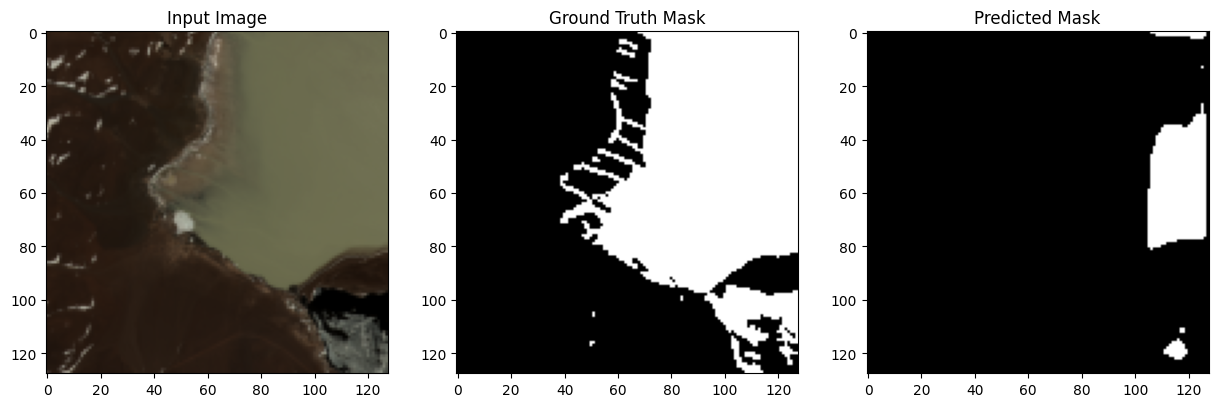

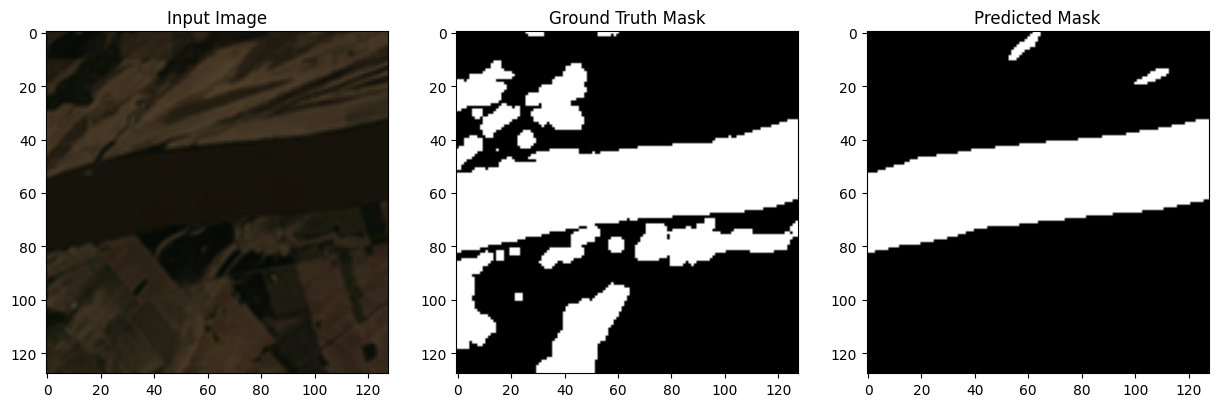

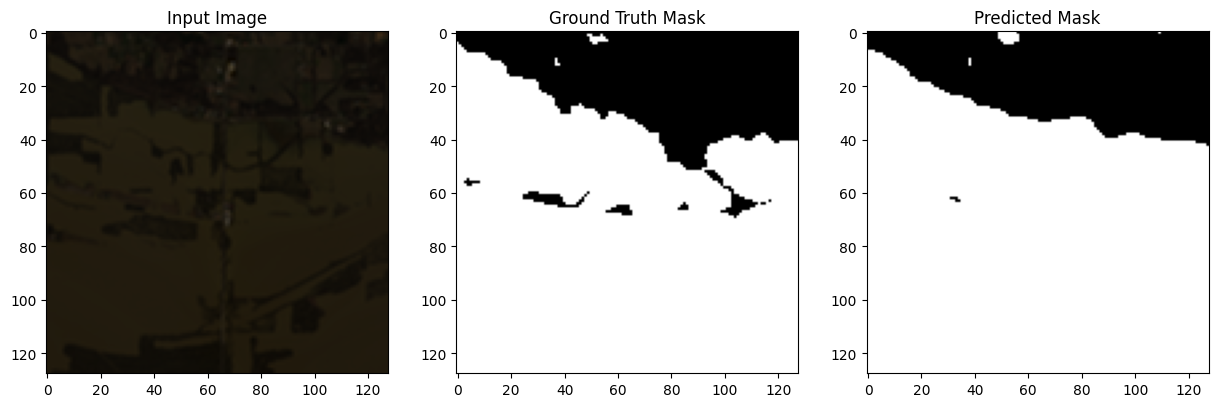

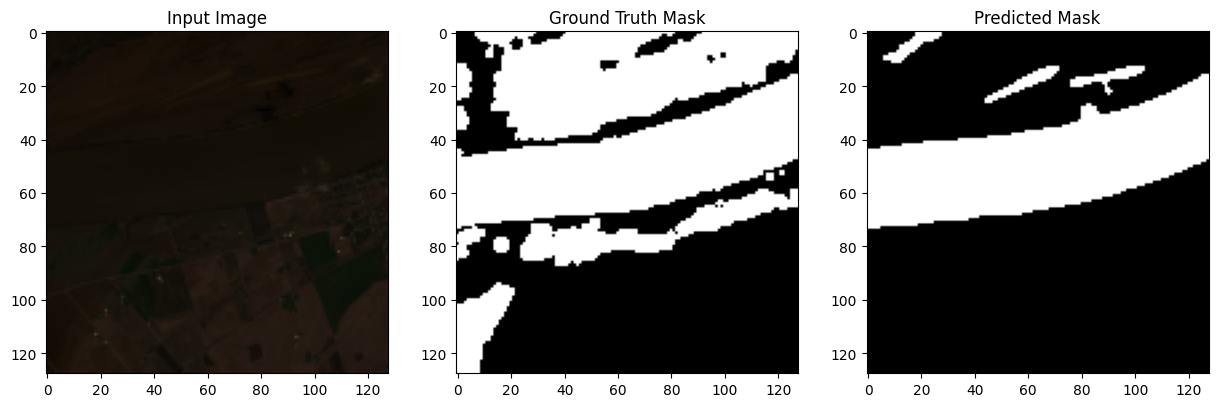

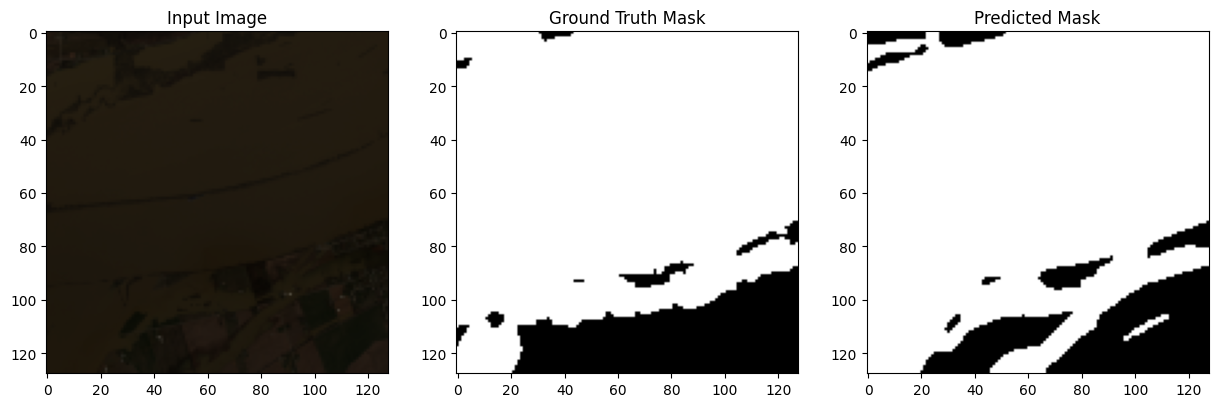

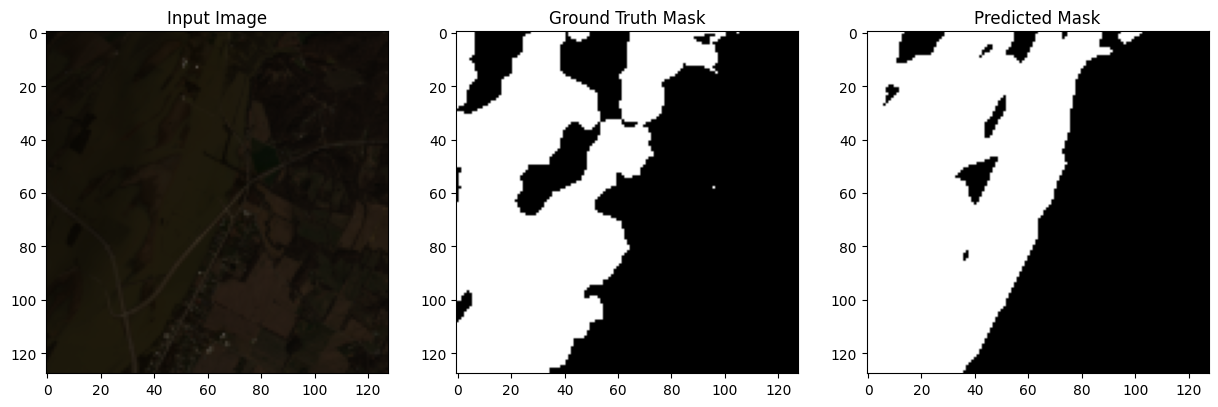

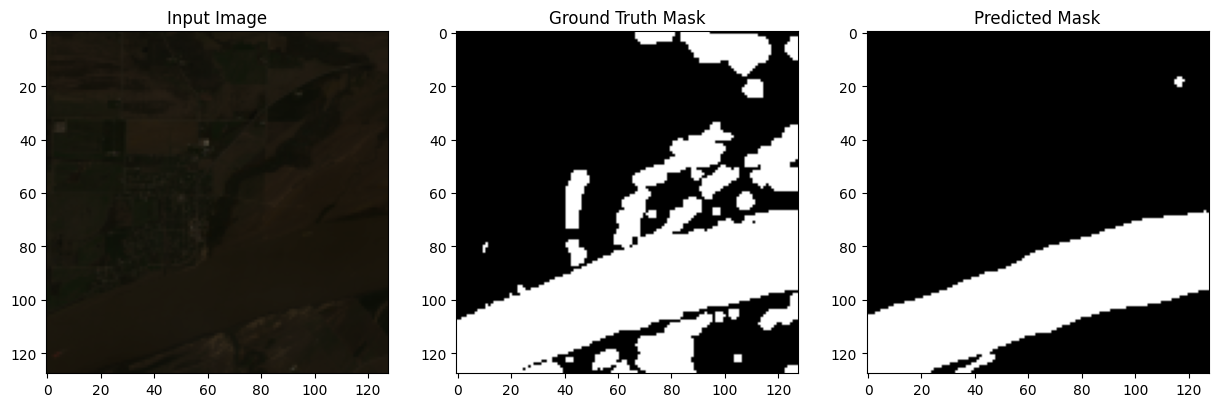

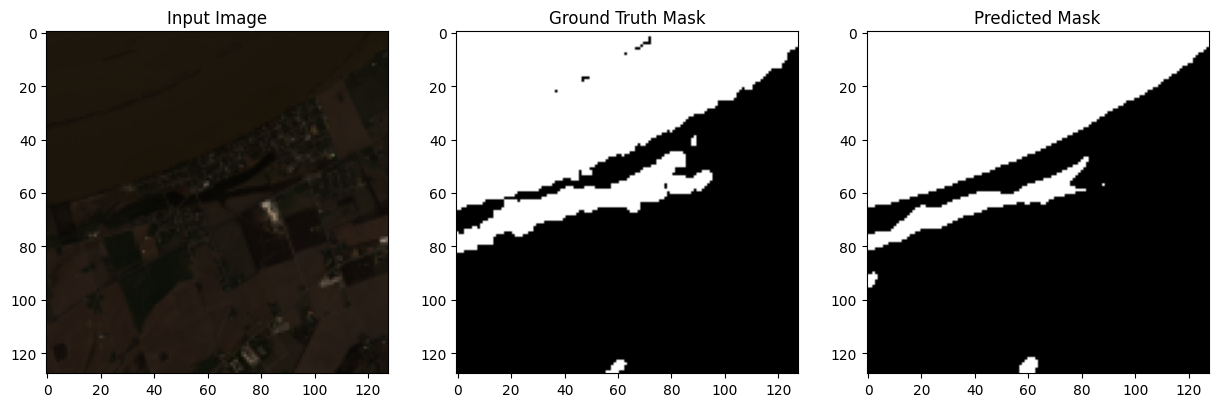

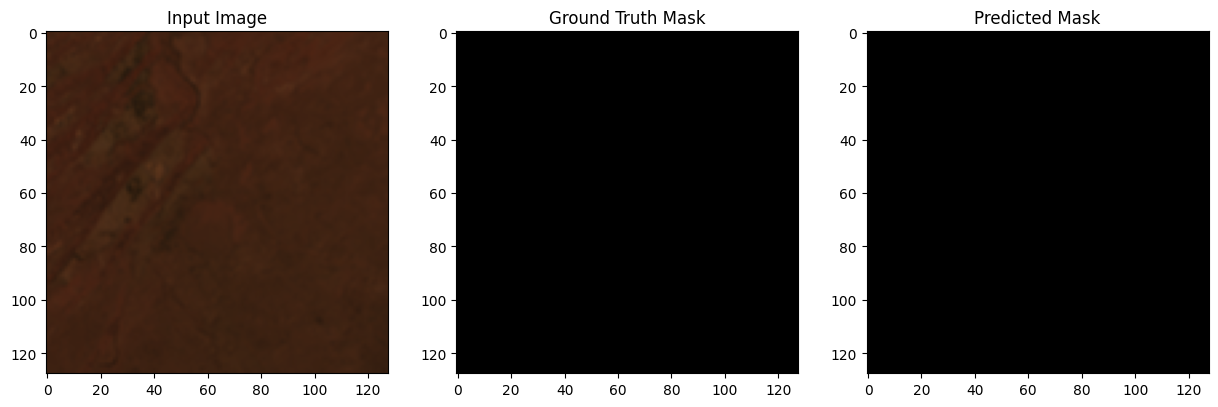

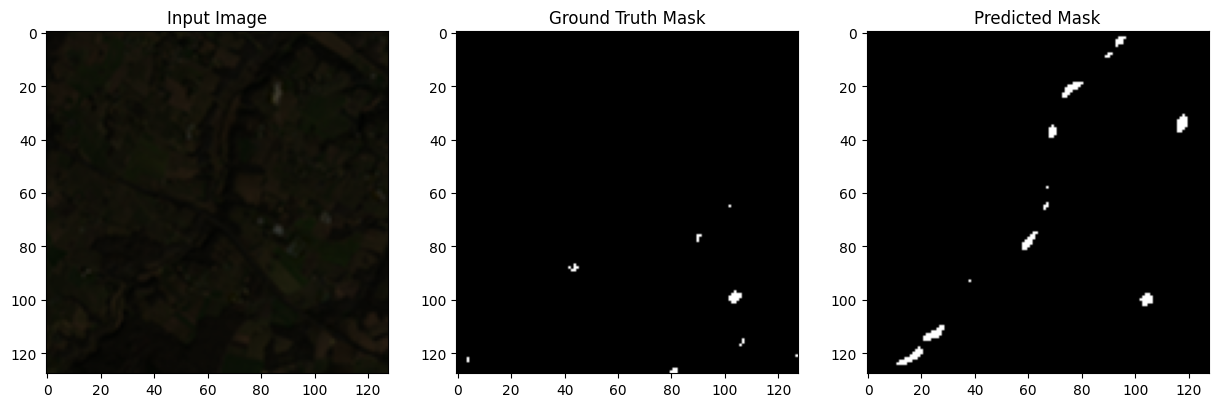

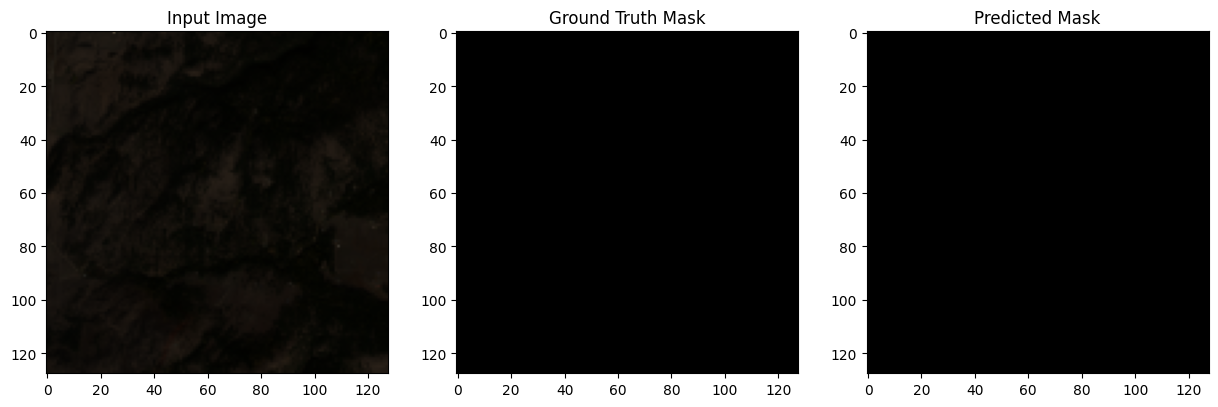

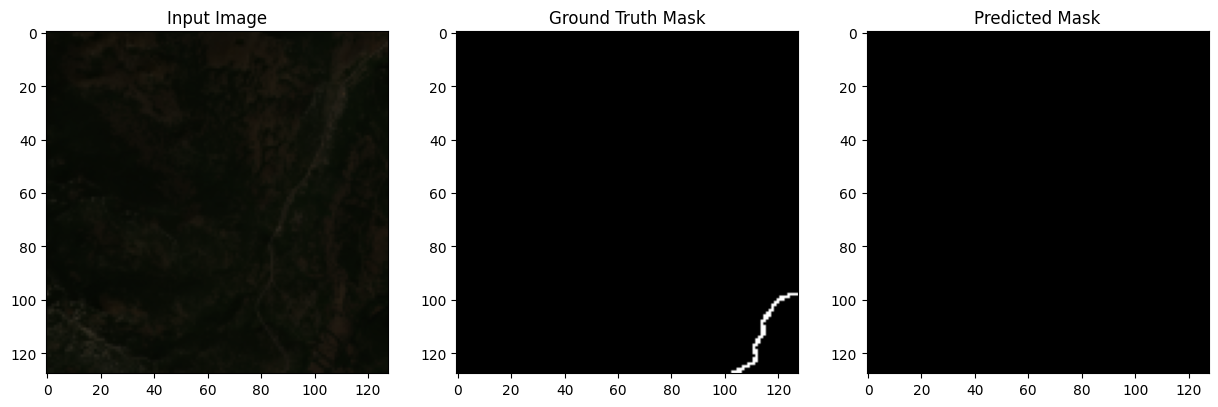

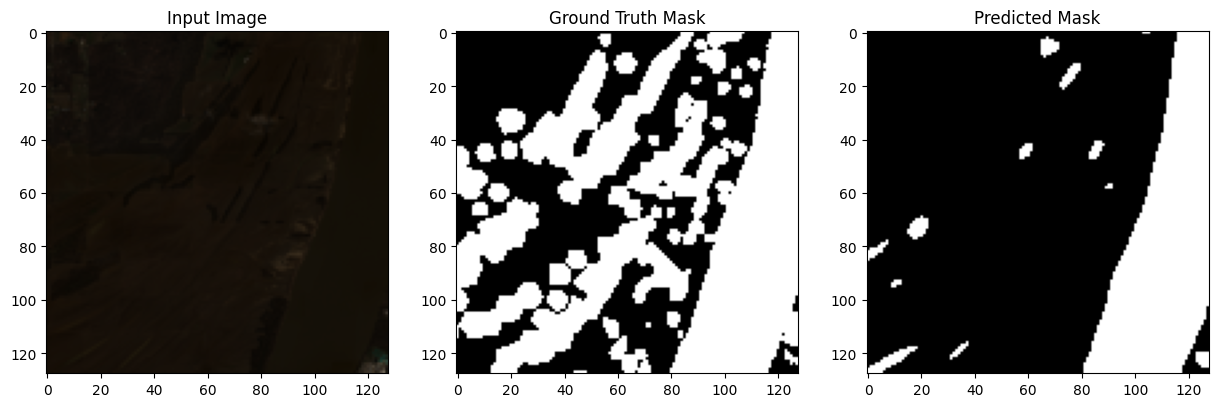

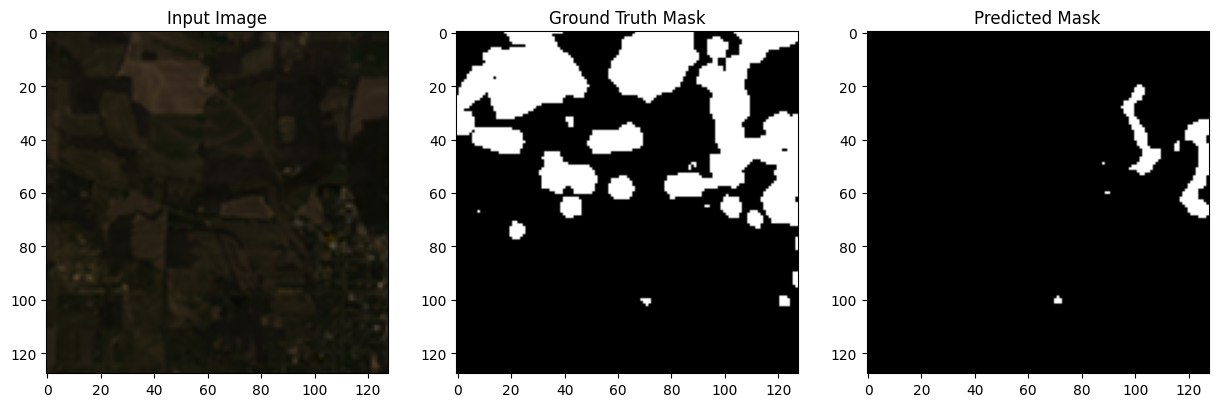

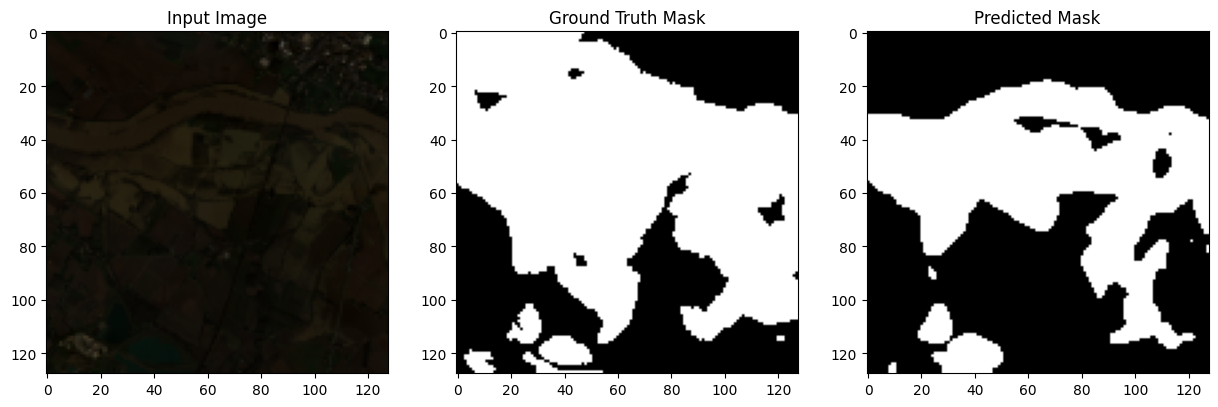

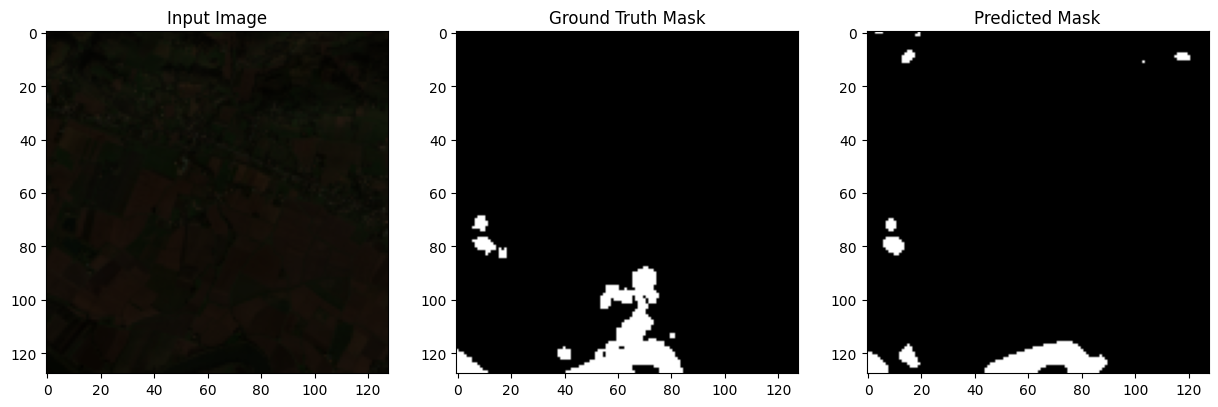

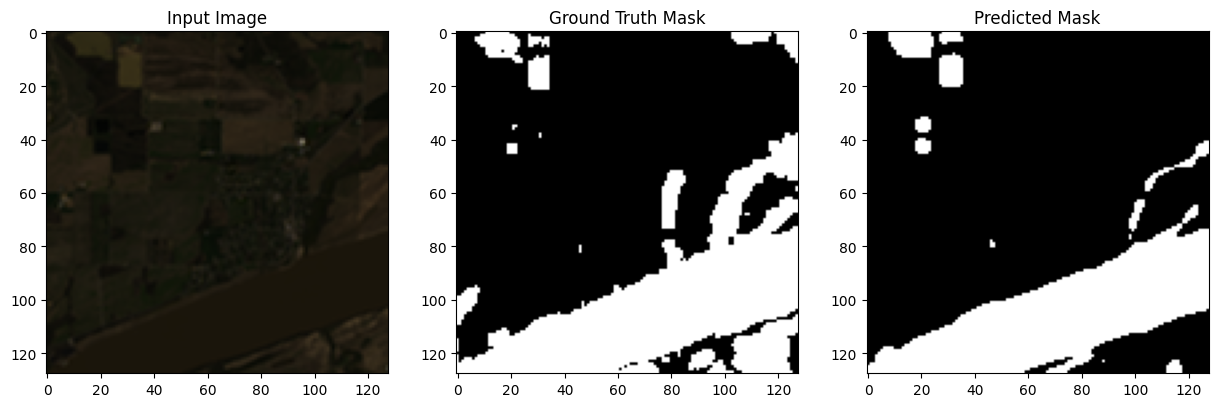

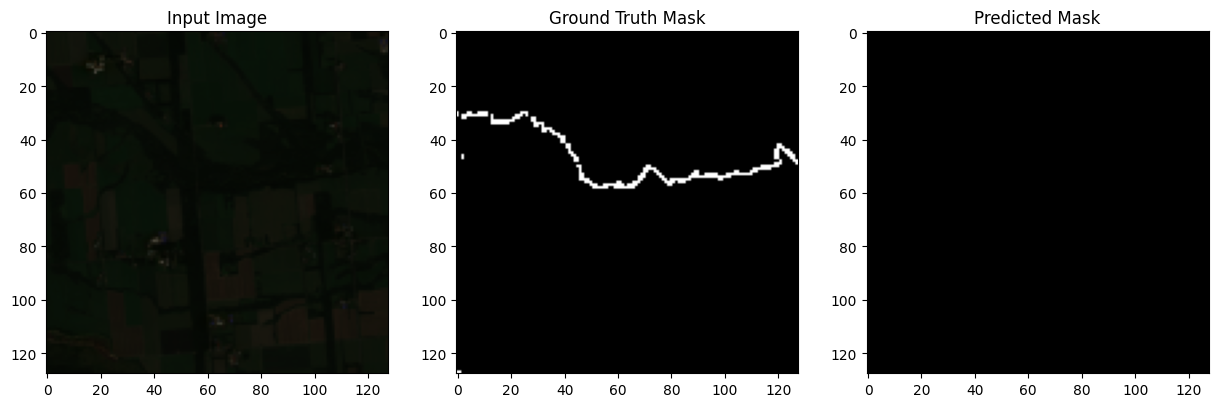

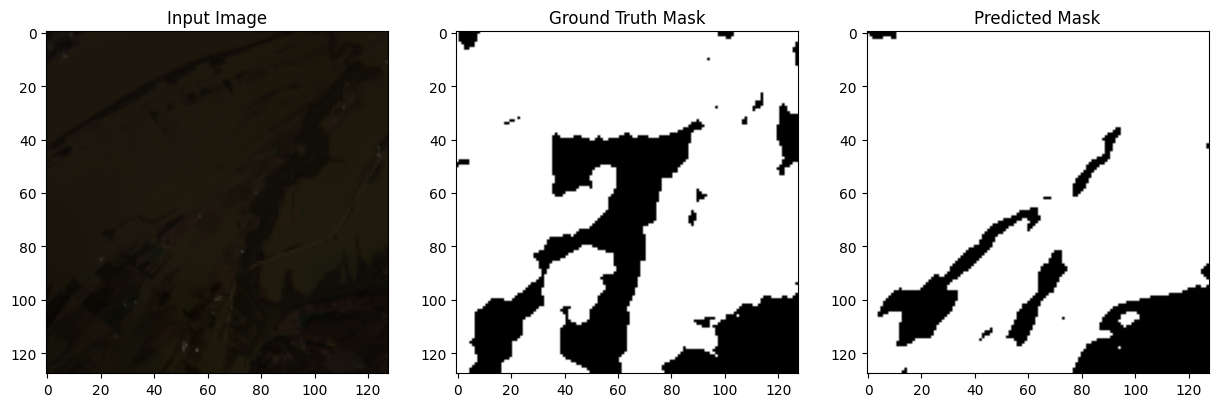

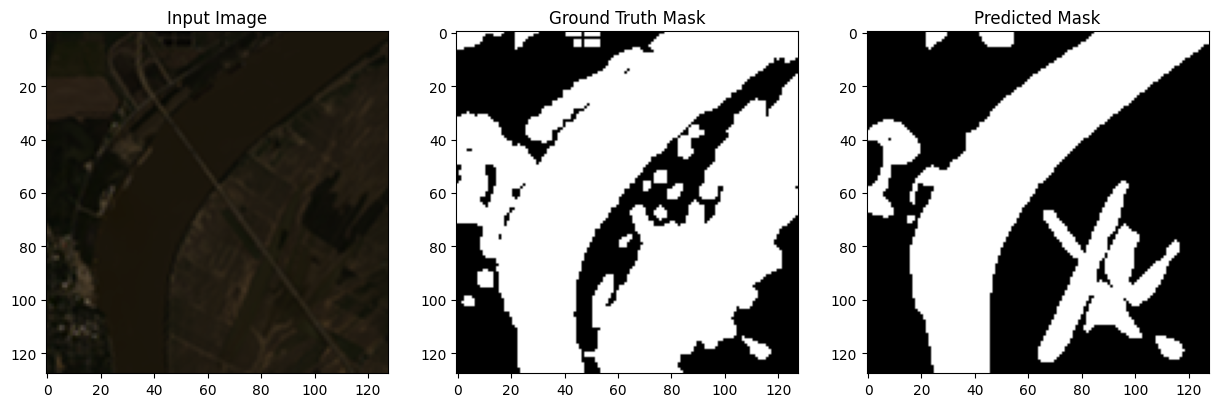

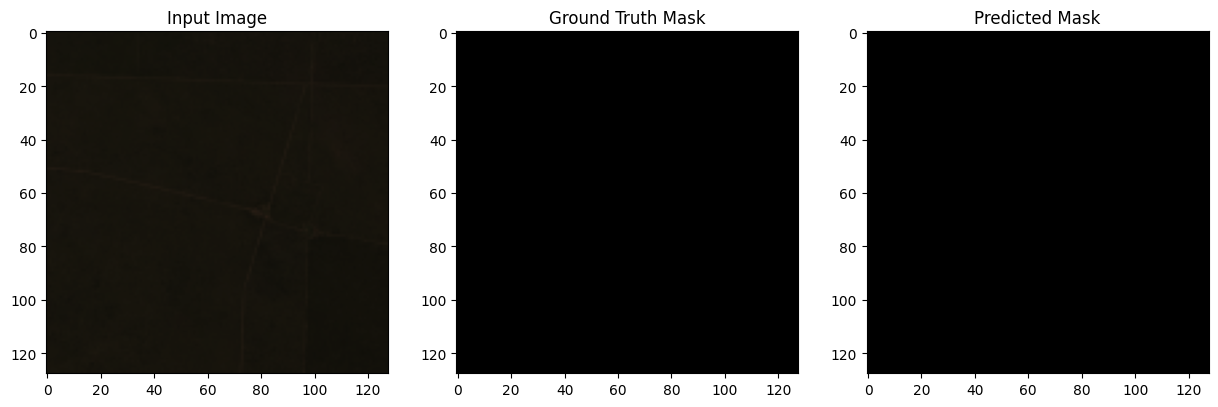

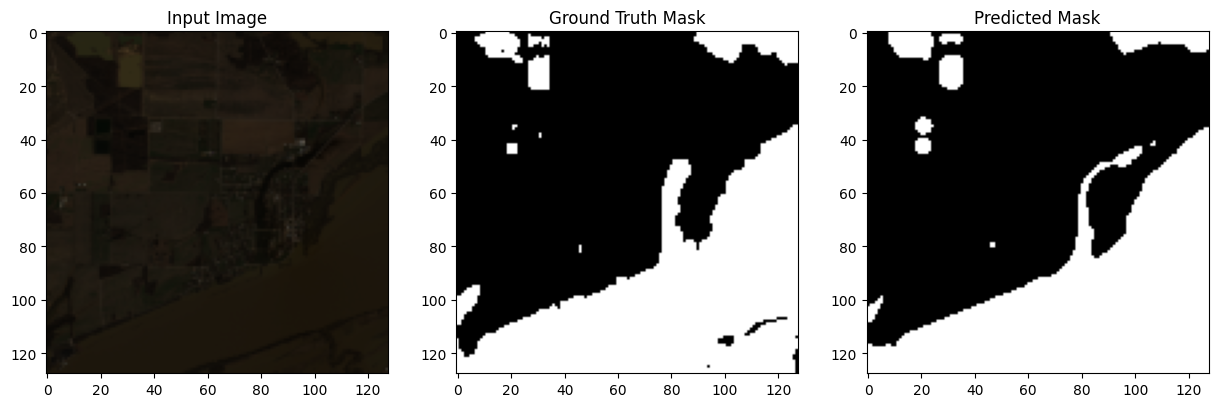

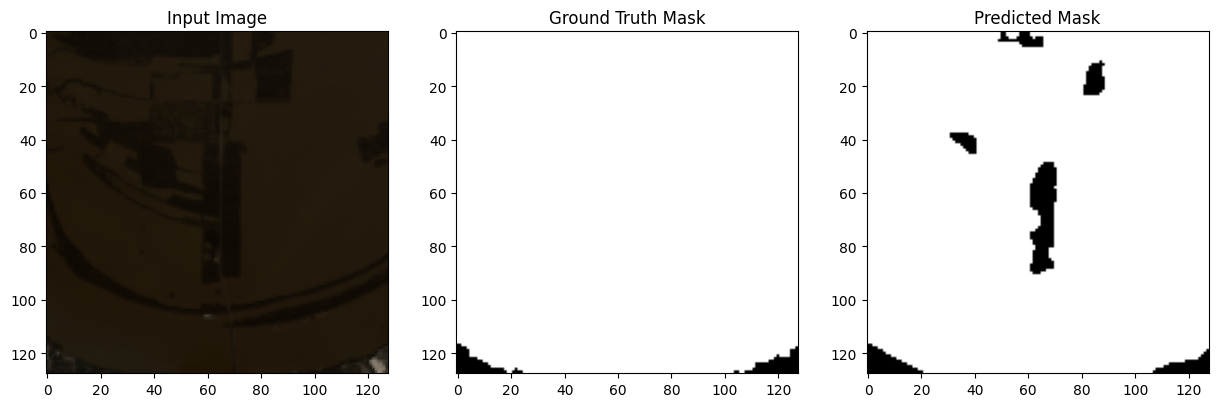

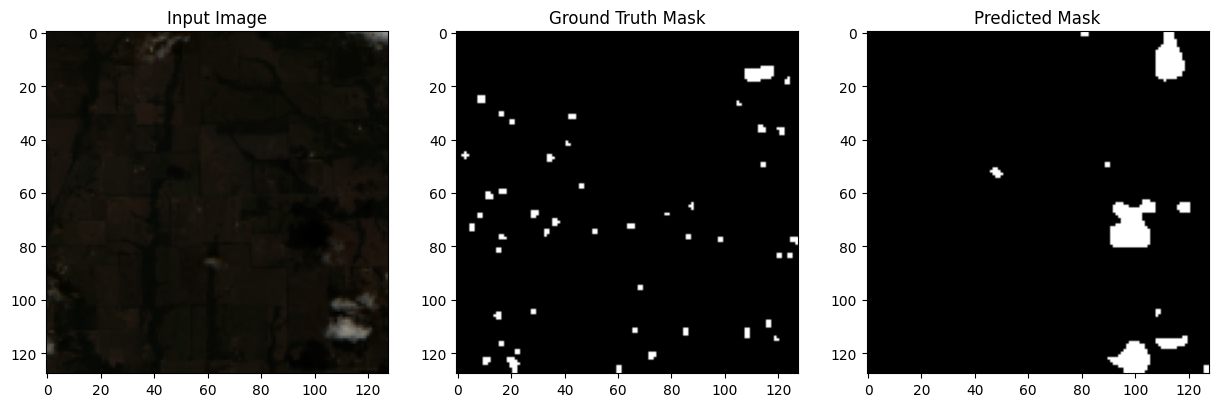

In [10]:
# Plot predictions
def plot_predictions(model, dataset, num_samples=3):
    for images, masks in dataset.take(num_samples):
        pred_masks = model.predict(images, verbose=0)
        pred_masks = (pred_masks > 0.5).astype(np.uint8)

        for i in range(len(images)):
            plt.figure(figsize=(15, 5))

            # Input Image (RGB bands)
            plt.subplot(1, 3, 1)
            plt.imshow(images[i].numpy()[:, :, [3, 2, 1]])
            plt.title("Input Image")

            # Ground Truth Mask
            plt.subplot(1, 3, 2)
            plt.imshow(masks[i].numpy()[:, :, 0], cmap="gray")
            plt.title("Ground Truth Mask")

            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(pred_masks[i][:, :, 0], cmap="gray")
            plt.title("Predicted Mask")

            plt.show()

# Visualize predictions
plot_predictions(model, test_tf_dataset)

In [12]:
# Save the model
model.save("/content/drive/MyDrive/Computer_Vision_intern/week_3/water_segmentation_model.h5")

# Load the model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Computer_Vision_intern/week_3/water_segmentation_model.h5")

In [18]:
!pip install transformers datasets
!pip install torch torchvision
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 905.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [34]:
!pip install tensorflow

# Load the Pre-trained DeepLabV3+ Model

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 12), include_top=False, weights=None
)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

# Define the DeepLabV3+ model
def deeplabv3_plus(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    skips = down_stack(inputs)
    x = skips[-1]

    x = layers.Conv2D(256, 1, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Upsampling and concatenation
    for skip in reversed(skips[:-1]):
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D((2, 2))(x) # Upsample once more to reach 128x128
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)  # Upsample once more to reach 128x128
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    return tf.keras.Model(inputs, outputs)

# Create the model
model = deeplabv3_plus(input_shape=(128, 128, 12))
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 128, 128, 12)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_5 (Functional) │ [(None, 64, 64, 96),   │        618,848 │ input_layer_9[0][0]    │
│                           │ (None, 32, 32, 144),   │                │                        │
│                           │ (None, 16, 16, 192),   │                │                        │
│                           │ (None, 8, 8, 576)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 8, 8, 256)      │        147,712 │ functional_5[0][3]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 8, 8, 256)      │          1,024 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_5           │ (None, 16, 16, 256)    │              0 │ batch_normalization_4… │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 16, 16, 448)    │              0 │ up_sampling2d_5[0][0], │
│ (Concatenate)             │                        │                │ functional_5[0][2]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 16, 16, 256)    │      1,032,448 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 16, 16, 256)    │          1,024 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_6           │ (None, 32, 32, 256)    │              0 │ batch_normalization_5… │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 32, 32, 400)    │              0 │ up_sampling2d_6[0][0], │
│ (Concatenate)             │                        │                │ functional_5[0][1]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 32, 32, 256)    │        921,856 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 32, 32, 256)    │          1,024 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_7           │ (None, 64, 64, 256)    │              0 │ batch_normalization_6… │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7        

 Total params: 4,718,689 (18.00 MB)

 Trainable params: 4,096,769 (15.63 MB)

 Non-trainable params: 621,920 (2.37 MB)

# Prepare the Data


In [74]:
import tensorflow as tf
import numpy as np
import rasterio
from PIL import Image

# Function to load and preprocess images & masks
def load_data(image_paths, mask_paths, target_size=(256, 256)):
    images, masks = [], []

    for img_path, mask_path in zip(image_paths, mask_paths):
        with rasterio.open(img_path) as img:
            image = img.read().astype(np.float32)  # Convert to float32
            image = np.transpose(image, (1, 2, 0))  # (128, 128, num_bands)
            image /= 65535.0  # Normalize to [0, 1]

        # Load mask
        mask = np.array(Image.open(mask_path), dtype=np.uint8)  # (128, 128)
        mask = np.expand_dims(mask, axis=-1)  # Convert to (128, 128, 1)

        # Resize mask to match model output
        mask = tf.image.resize(mask, target_size, method="nearest")  # (256, 256, 1)

        images.append(image)
        masks.append(mask)

    # Convert to NumPy arrays
    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)

    return tf.data.Dataset.from_tensor_slices((images, masks))

# Load datasets
train_dataset = load_data(train_image_paths, train_mask_paths).batch(8).prefetch(tf.data.AUTOTUNE)
val_dataset = load_data(val_image_paths, val_mask_paths).batch(8).prefetch(tf.data.AUTOTUNE)
test_dataset = load_data(test_image_paths, test_mask_paths).batch(8).prefetch(tf.data.AUTOTUNE)


# Modify the Model

In [46]:
inputs = tf.keras.Input(shape=(128, 128, 12))
outputs = model(inputs)

final_model = tf.keras.Model(inputs, outputs)
final_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 128, 128, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_6 (Functional)            │ (None, 256, 256, 1)         │       4,718,689 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,718,689 (18.00 MB)

 Trainable params: 4,096,769 (15.63 MB)

 Non-trainable params: 621,920 (2.37 MB)

# Fine-Tune the Model

In [ ]:
# Compile the model
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = final_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1878s 75s/step - accuracy: 0.5047 - loss: 0.7596 - val_accuracy: 0.6967 - val_loss: 0.6814
Epoch 2/10
 1/25 ━━━━━━━━━━━━━━━━━━━━ 35:36 89s/step - accuracy: 0.6753 - loss: 0.6811

# Evaluate and Predict

In [ ]:
# Evaluate the model
results = final_model.evaluate(test_dataset)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

# Function for prediction
def predict(model, image_path):
    with rasterio.open(image_path) as img:
        image = img.read()  # Shape: (num_bands, 128, 128)
        image = np.transpose(image, (1, 2, 0))

    # Preprocess the image
    image = image[tf.newaxis, ...]

    # Predict
    pred_mask = model.predict(image)
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Visualize the result
    plt.imshow(pred_mask[0, :, :, 0], cmap="gray")
    plt.title("Predicted Mask")
    plt.show()


predict(final_model, "/content/drive/MyDrive/Computer_Vision_intern/week_3/new_image.tif")